In [301]:
from pandas import read_csv, DataFrame
from matplotlib.pyplot import figure, subplots
from ts_functions import HEIGHT, split_dataframe

def split_dataframe(data, trn_pct=0.70):
    trn_size = int(len(data) * trn_pct)
    df_cp = data.copy()
    train: DataFrame = df_cp.iloc[:trn_size, :]
    test: DataFrame = df_cp.iloc[trn_size:]
    return train, test

target = 'QV2M'
index_col = 'date'

In [302]:
def plot_forecasting_series(trn, tst, prd_trn, prd_tst, figname: str, x_label: str = 'time', y_label:str =''):
    _, ax = subplots(1,1,figsize=(5*HEIGHT, HEIGHT), squeeze=True)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(figname)
    ax.plot(trn.index, trn, label='train', color='b')
    ax.plot(trn.index, prd_trn, '--y', label='train prediction')
    ax.plot(tst.index, tst, label='test', color='g')
    ax.plot(tst.index, prd_tst, '--r', label='test prediction')
    ax.legend(prop={'size': 5})

In [303]:
from sklearn.base import RegressorMixin
from ts_functions import PREDICTION_MEASURES, plot_evaluation_results, plot_forecasting_series

class PersistenceRegressor (RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last = 0

    def fit(self, X: DataFrame):
        self.last = X.iloc[-1,0]
        print(self.last)

    def predict(self, X: DataFrame):
        prd = X.shift().values
        prd[0] = self.last
        return prd


#### Data Dimensionality

In [304]:
data = read_csv('datasets/time_drought.csv', index_col='date', sep=',', decimal='.', parse_dates=True)
data.shape
data.head()

,PRECTOT,PS,T2M,T2MDEW,T2MWET,TS,QV2M
date,,,,,,,
2000-01-01,0.22,100.51,14.74,13.51,13.51,14.65,9.65
2000-02-01,0.20,100.55,16.69,14.71,14.71,16.60,10.42
2000-03-01,3.65,100.15,18.49,16.52,16.52,18.41,11.76
2000-04-01,15.95,100.29,11.40,6.09,6.10,11.31,6.42
2000-05-01,0.00,101.15,3.86,-3.29,-3.20,2.65,2.95


In [305]:
data.shape #daily is the most atomic aggregation

(7671, 7)

In [306]:
from pandas import read_csv
from matplotlib.pyplot import figure, xticks, show
from ts_functions import plot_series, HEIGHT

data = read_csv('datasets/time_drought.csv', index_col='date', sep=',', decimal='.', parse_dates=True)
#data.index = pd.to_datetime(data.index, format="%d-%m-%Y")
data.sort_index(inplace=True)
print(data.shape)
data.drop('PRECTOT', axis=1, inplace=True)
data.drop('PS', axis=1, inplace=True)
data.drop('T2M', axis=1, inplace=True)
data.drop('T2MDEW', axis=1, inplace=True)
data.drop('T2MWET', axis=1, inplace=True)
data.drop('TS', axis=1, inplace=True)

print("Nr. Records = ", data.shape[0])
print("First timestamp", data.index[0])
print("Last timestamp", data.index[-1])

(7671, 7)
Nr. Records =  7671
First timestamp 2000-01-01 00:00:00
Last timestamp 2020-12-31 00:00:00


#### Data Granularity

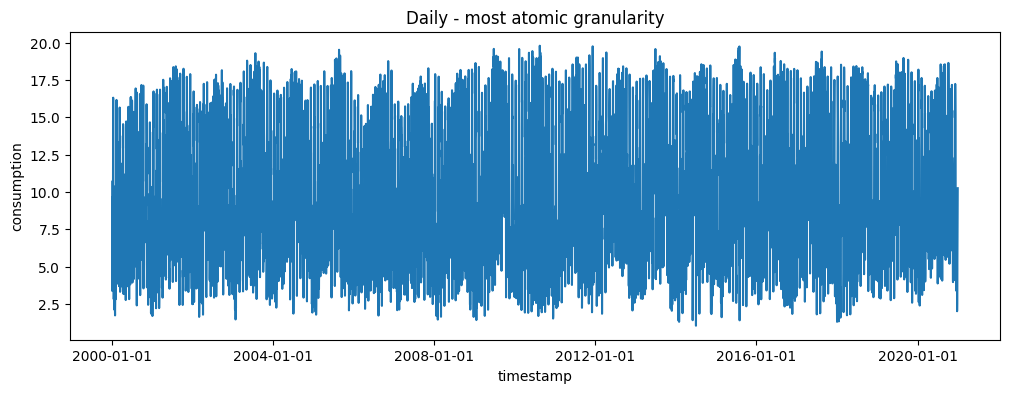

In [307]:
day_df = data.copy().groupby(data.index.date).mean()
figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(day_df, title='Daily - most atomic granularity', x_label='timestamp', y_label='consumption')

savefig('images/set_2_granularity_atomic.png')
show()

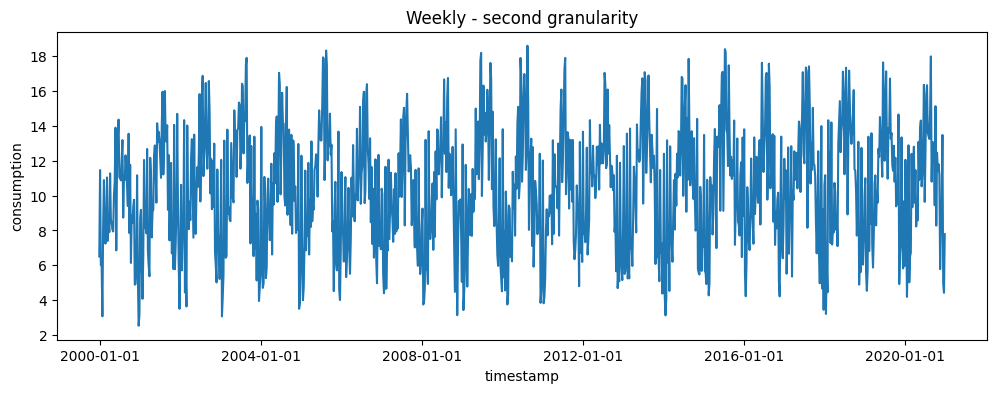

In [308]:
index = data.index.to_period('W')
week_df = data.copy().groupby(index).mean()
week_df['timestamp'] = index.drop_duplicates().to_timestamp()
week_df.set_index('timestamp', drop=True, inplace=True)
figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(week_df, title='Weekly - second granularity', x_label='timestamp', y_label='consumption')

savefig('images/set_2_granularity_weekly.png')
show()

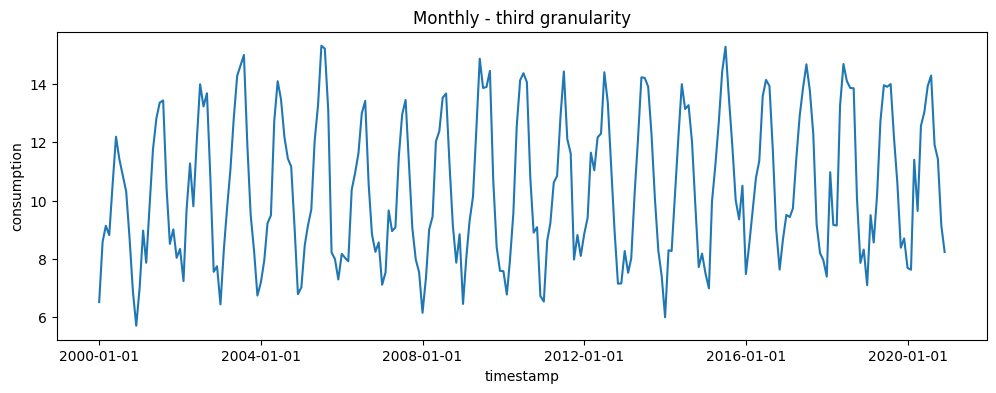

In [309]:
index = data.index.to_period('M')
month_df = data.copy().groupby(index).mean()
month_df['timestamp'] = index.drop_duplicates().to_timestamp()
month_df.set_index('timestamp', drop=True, inplace=True)
figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(month_df, title='Monthly - third granularity', x_label='timestamp', y_label='consumption')

savefig('images/set_2_granularity_monthly.png')
show()

#### Data Distribution

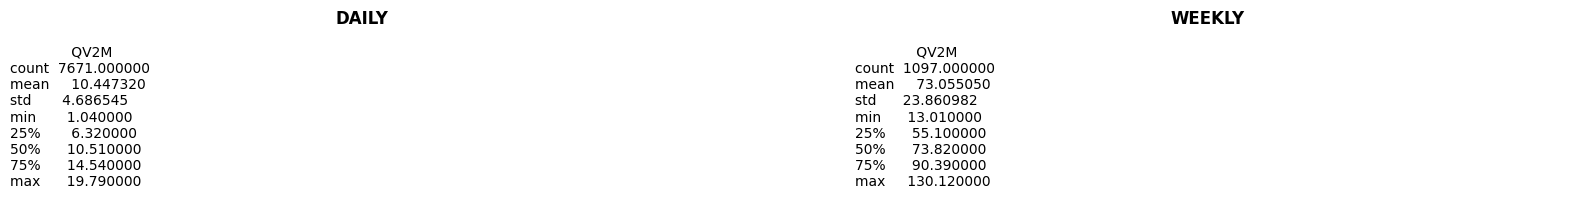

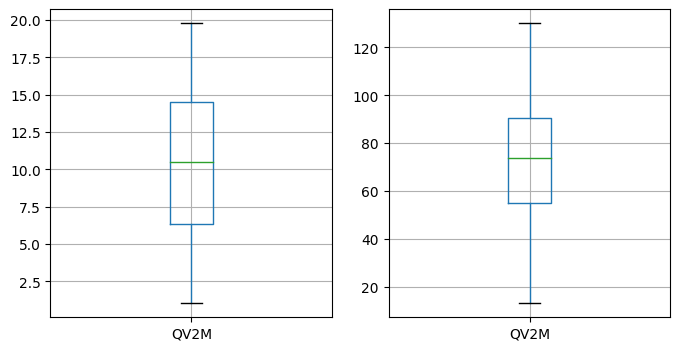

In [310]:
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt

index = data.index.to_period('W')
week_df = data.copy().groupby(index).sum()
week_df['timestamp'] = index.drop_duplicates().to_timestamp()
week_df.set_index('timestamp', drop=True, inplace=True)
_, axs = subplots(1, 2, figsize=(5*HEIGHT, HEIGHT/2))
axs[0].grid(False)
axs[0].set_axis_off()
plt.rcParams['axes.titley'] = 1.0
axs[0].set_title('DAILY', fontweight="bold")
axs[0].text(0, 0, str(data.describe()))
axs[1].grid(False)
axs[1].set_axis_off()
axs[1].set_title('WEEKLY', fontweight="bold")
axs[1].text(0, 0, str(week_df.describe()))
show()

_, axs = subplots(1, 2, figsize=(2*HEIGHT, HEIGHT))
data.boxplot(ax=axs[0])
week_df.boxplot(ax=axs[1])
show()

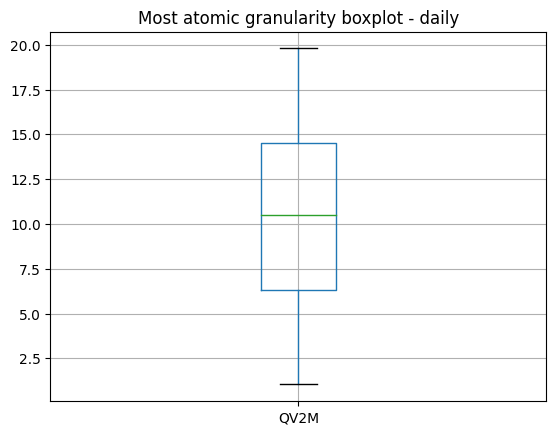

In [311]:
data.boxplot()
plt.title('Most atomic granularity boxplot - daily')
savefig('images/set_2_boxplot_atomic.png')

#### Variables distribution

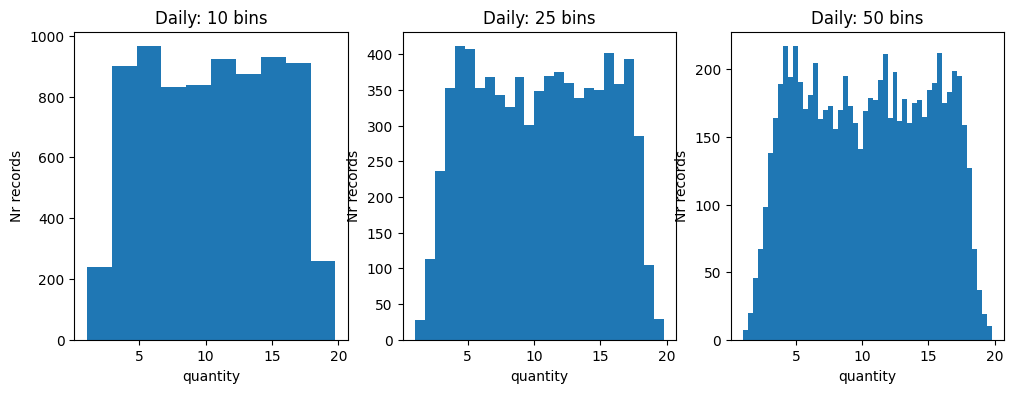

In [312]:
bins = (10, 25, 50)
_, axs = subplots(1, len(bins), figsize=(len(bins)*HEIGHT, HEIGHT))
for j in range(len(bins)):
    axs[j].set_title('Daily: %d bins'%bins[j])
    axs[j].set_xlabel('quantity')
    axs[j].set_ylabel('Nr records')
    axs[j].hist(data.values, bins=bins[j])
savefig('images/set_2_histogram_day')
show()

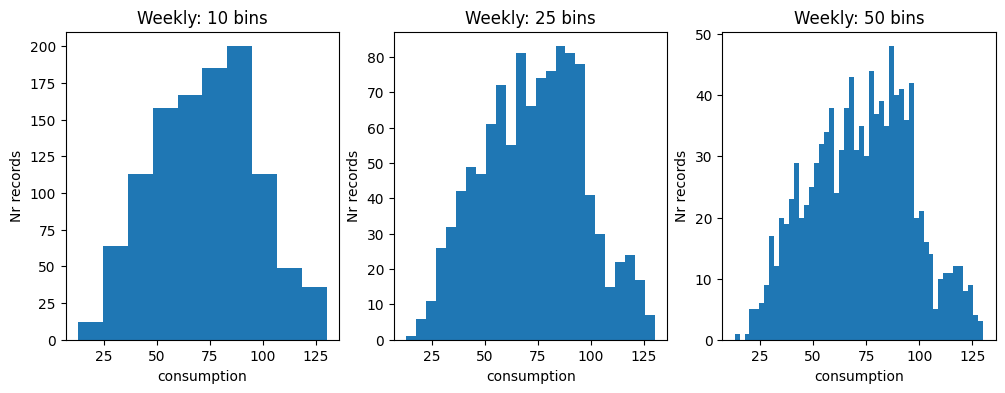

In [313]:
index = data.index.to_period('W')
week_df = data.copy().groupby(index).sum()
week_df['timestamp'] = index.drop_duplicates().to_timestamp()
week_df.set_index('timestamp', drop=True, inplace=True)

_, axs = subplots(1, len(bins), figsize=(len(bins)*HEIGHT, HEIGHT))
for j in range(len(bins)):
    axs[j].set_title('Weekly: %d bins'%bins[j])
    axs[j].set_xlabel('consumption')
    axs[j].set_ylabel('Nr records')
    axs[j].hist(week_df.values, bins=bins[j])
savefig('images/set_2_histogram_week')
show()

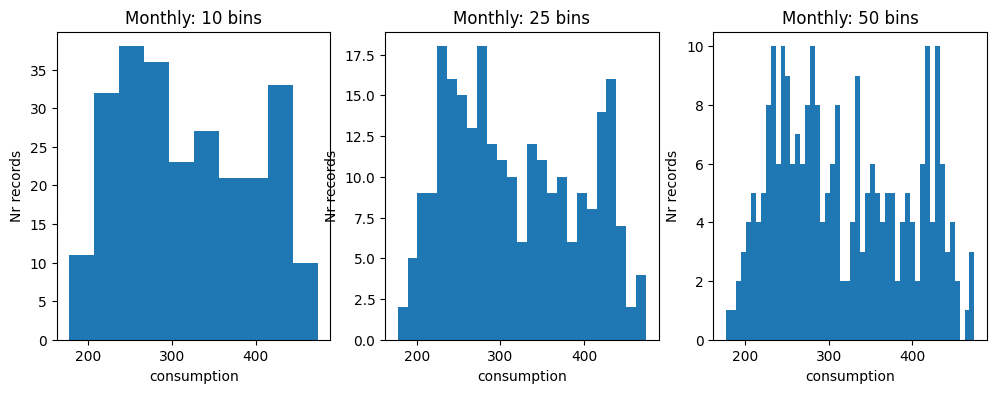

In [314]:
index = data.index.to_period('M')
month_df = data.copy().groupby(index).sum()
month_df['timestamp'] = index.drop_duplicates().to_timestamp()
month_df.set_index('timestamp', drop=True, inplace=True)

_, axs = subplots(1, len(bins), figsize=(len(bins)*HEIGHT, HEIGHT))
for j in range(len(bins)):
    axs[j].set_title('Monthly: %d bins'%bins[j])
    axs[j].set_xlabel('consumption')
    axs[j].set_ylabel('Nr records')
    axs[j].hist(month_df.values, bins=bins[j])
savefig('images/set_2_histogram_month')
show()

#### Stationary study

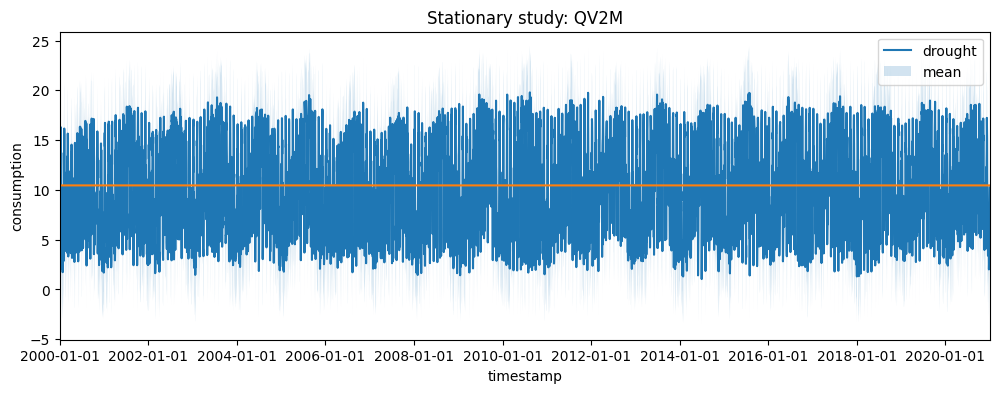

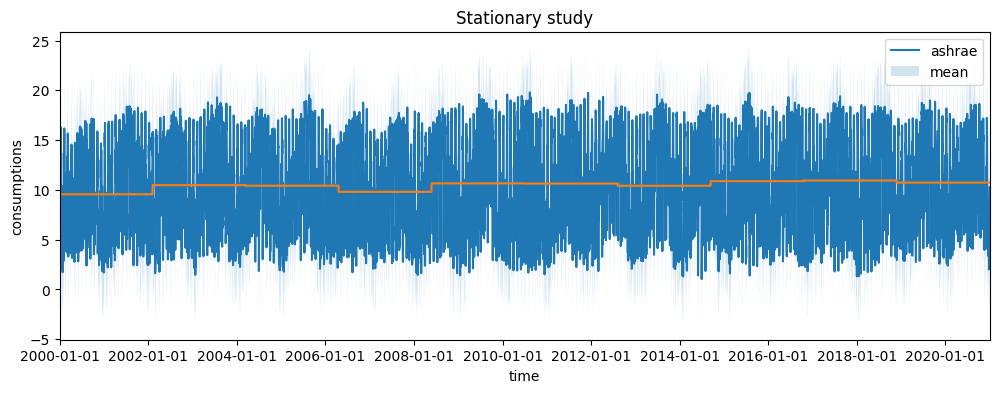

In [315]:
dt_series = Series(data['QV2M'])
mean_line = Series(ones(len(dt_series.values)) * dt_series.mean(), index=dt_series.index)
series = {'drought': dt_series, 'mean': mean_line}
figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(series, x_label='timestamp', y_label='consumption', title='Stationary study: QV2M', show_std=True)
show()

BINS = 10
line = []
n = len(dt_series)
for i in range(BINS):
    b = dt_series[i*n//BINS:(i+1)*n//BINS]
    mean = [b.mean()] * (n//BINS)
    line += mean
line += [line[-1]] * (n - len(line))
mean_line = Series(line, index=dt_series.index)
series = {'ashrae': dt_series, 'mean': mean_line}
figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(series, x_label='time', y_label='consumptions', title='Stationary study', show_std=True)
savefig('images/set_2_stationary_qv2m')
show()

#### Transformation: aggregation

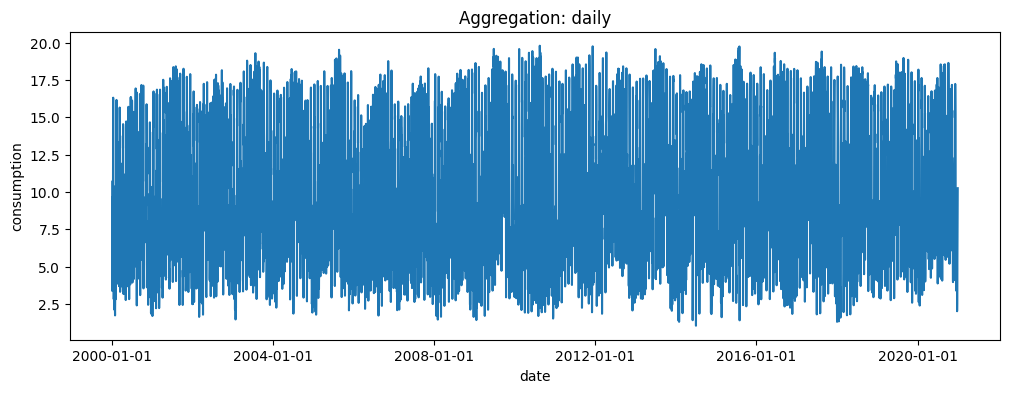

In [316]:
def aggregate_by(data: Series, index_var: str, period: str):
    index = data.index.to_period(period)
    agg_df = data.copy().groupby(index).mean()
    agg_df[index_var] = index.drop_duplicates().to_timestamp()
    agg_df.set_index(index_var, drop=True, inplace=True)
    return agg_df

index = 'date'

figure(figsize=(3*HEIGHT, HEIGHT))
agg_df = aggregate_by(data, index, 'D')
plot_series(agg_df, title='Aggregation: daily', x_label=index, y_label='consumption')
savefig('images/set_2_aggregation_daily')
show()

2.34
{'Persistence': 0.415684035499147}
{'RMSE': [3.5277570603127035, 3.5408583039533936], 'MAE': [2.4682496088997046, 2.4508394160583946]} {'R2': [0.43582756694412705, 0.415684035499147]}


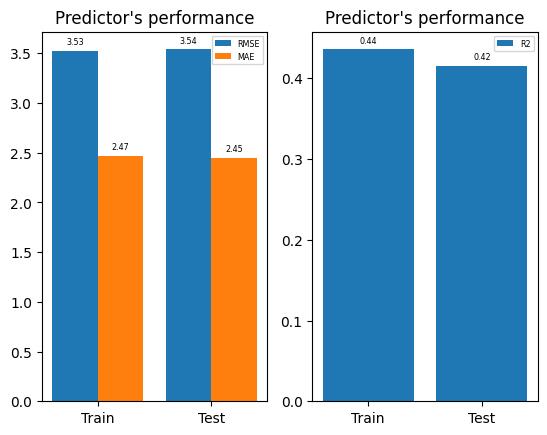

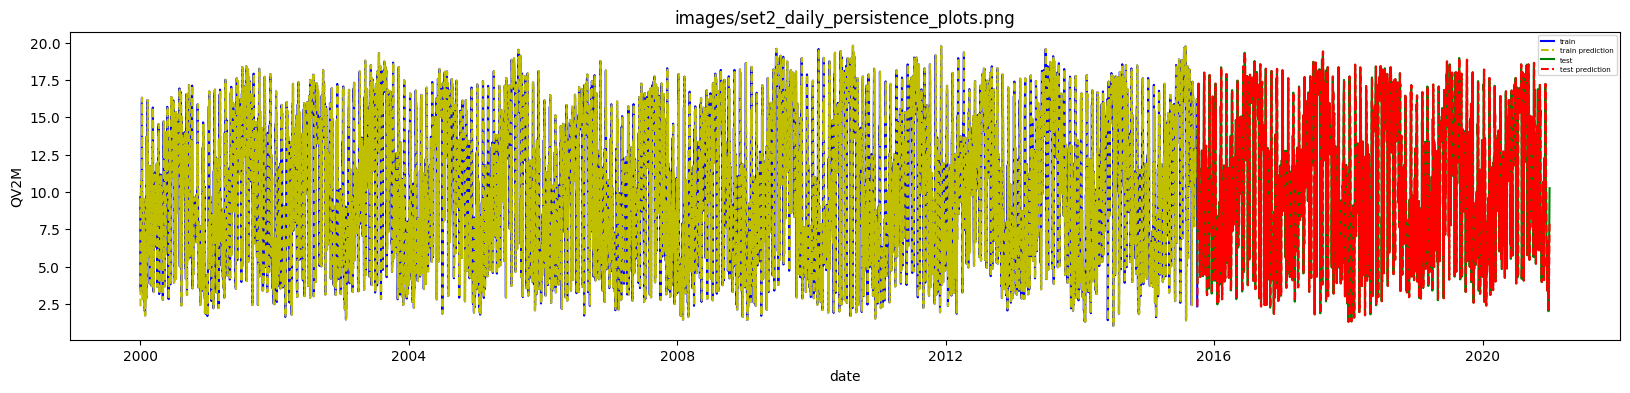

In [317]:
train, test = split_dataframe(data, trn_pct=0.75)

flag_pct = False
eval_results = {}
measure = 'R2'

fr_mod = PersistenceRegressor()
fr_mod.fit(train)
prd_trn = fr_mod.predict(train)
prd_tst = fr_mod.predict(test)

eval_results['Persistence'] = PREDICTION_MEASURES[measure](test.values, prd_tst)
print(eval_results)

plot_evaluation_results(train.values, prd_trn, test.values, prd_tst, f'images/set2_daily_persistence_eval.png')
savefig('images/set_2_aggregation_results_daily')
plot_forecasting_series(train, test, prd_trn, prd_tst, f'images/set2_daily_persistence_plots.png', x_label=index_col, y_label=target)

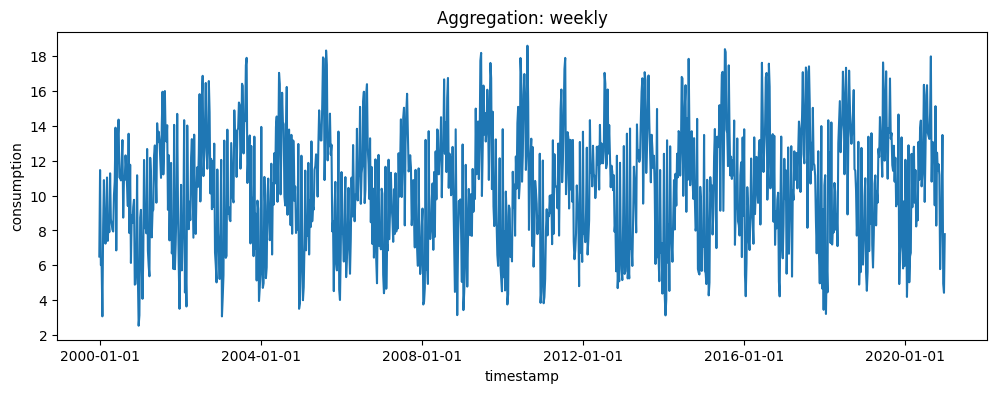

In [318]:
figure(figsize=(3*HEIGHT, HEIGHT))
agg_df = aggregate_by(data, index, 'W')
plot_series(agg_df, title='Aggregation: weekly', x_label='timestamp', y_label='consumption')
savefig('images/set_2_aggregation_weekly')
show()

12.015714285714285
{'Persistence': -0.21925326924709942}
{'RMSE': [3.5885264919165434, 3.6868673905965426], 'MAE': [2.839654153632256, 2.9531142857142854]} {'R2': [-0.11144445929151581, -0.21925326924709942]}


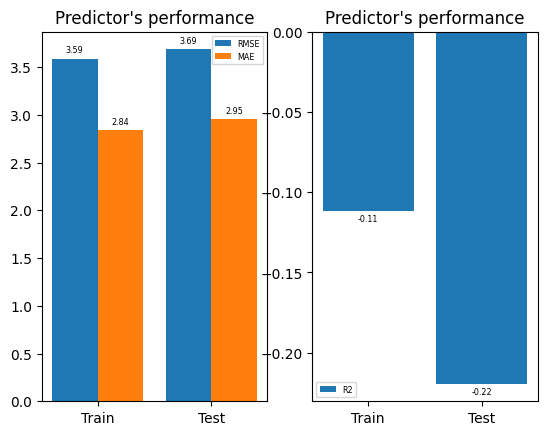

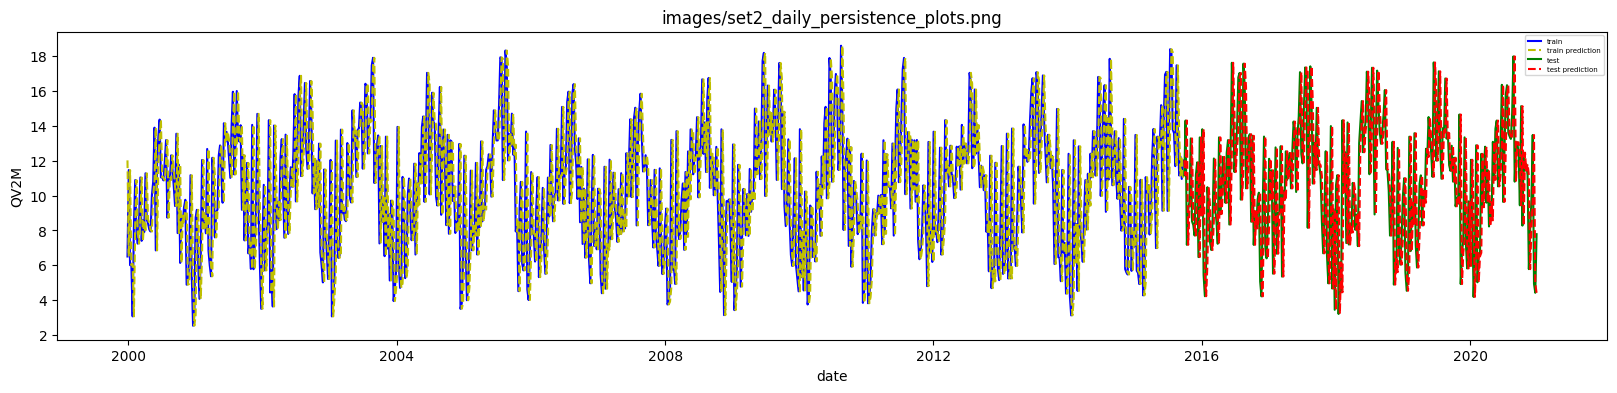

In [319]:
train, test = split_dataframe(agg_df, trn_pct=0.75)

fr_mod = PersistenceRegressor()
fr_mod.fit(train)
prd_trn = fr_mod.predict(train)
prd_tst = fr_mod.predict(test)

eval_results['Persistence'] = PREDICTION_MEASURES[measure](test.values, prd_tst)
print(eval_results)

plot_evaluation_results(train.values, prd_trn, test.values, prd_tst, f'images/set2_daily_persistence_eval.png')
savefig('images/set_2_aggregation_results_weekly')
plot_forecasting_series(train, test, prd_trn, prd_tst, f'images/set2_daily_persistence_plots.png', x_label=index_col, y_label=target)

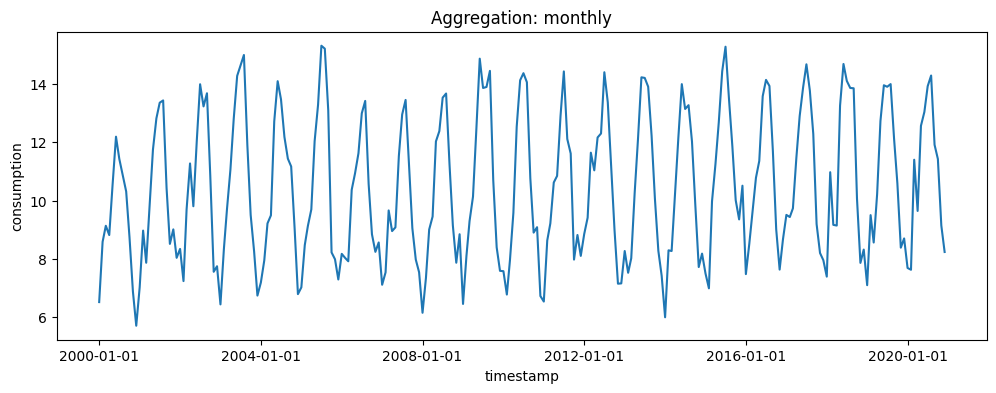

In [320]:
figure(figsize=(3*HEIGHT, HEIGHT))
agg_df = aggregate_by(data, index, 'M')
plot_series(agg_df, title='Aggregation: monthly', x_label='timestamp', y_label='consumption')
savefig('images/set_2_aggregation_monthly')
show()

11.844333333333333
{'Persistence': 0.46107744017127394}
{'RMSE': [1.6457012546003615, 1.7073699960289326], 'MAE': [1.3549251944505398, 1.3605130080706116]} {'R2': [0.5613767729551589, 0.46107744017127394]}


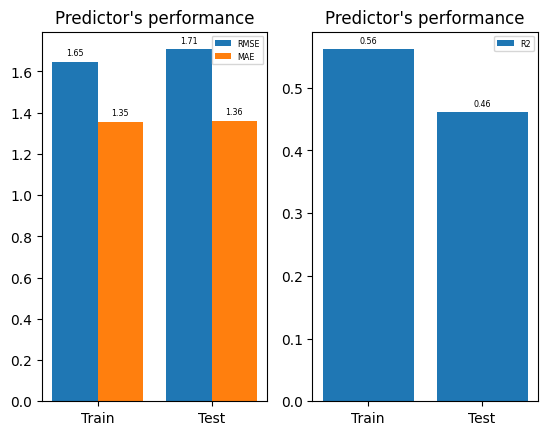

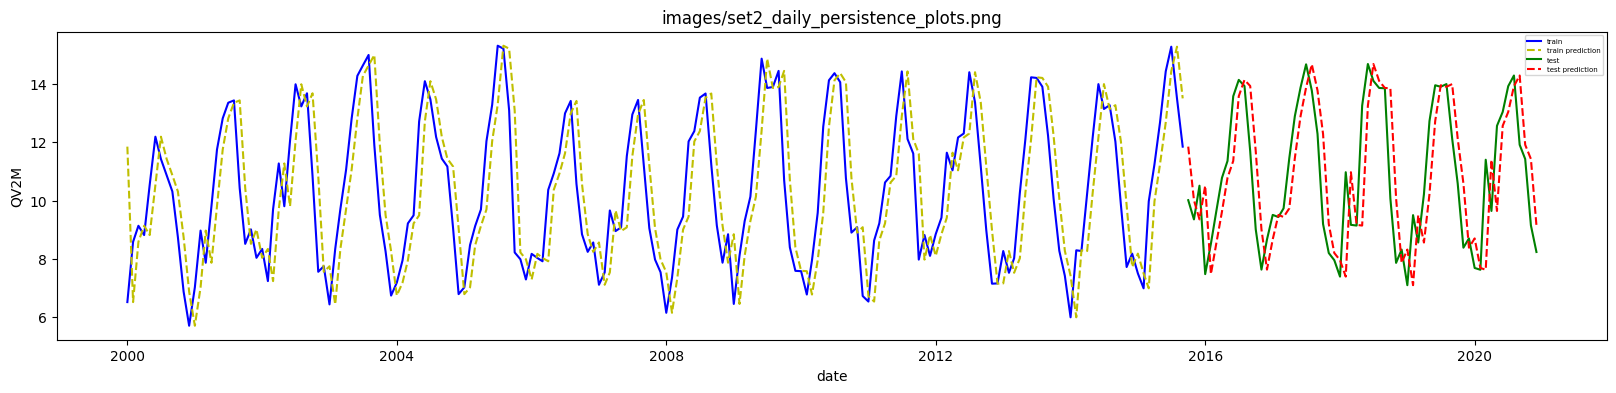

In [321]:
train, test = split_dataframe(agg_df, trn_pct=0.75)

fr_mod = PersistenceRegressor()
fr_mod.fit(train)
prd_trn = fr_mod.predict(train)
prd_tst = fr_mod.predict(test)

eval_results['Persistence'] = PREDICTION_MEASURES[measure](test.values, prd_tst)
print(eval_results)

plot_evaluation_results(train.values, prd_trn, test.values, prd_tst, f'images/set2_daily_persistence_eval.png')
savefig('images/set_2_aggregation_results_monthly')
plot_forecasting_series(train, test, prd_trn, prd_tst, f'images/set2_daily_persistence_plots.png', x_label=index_col, y_label=target)

#### Transformation: smoothing

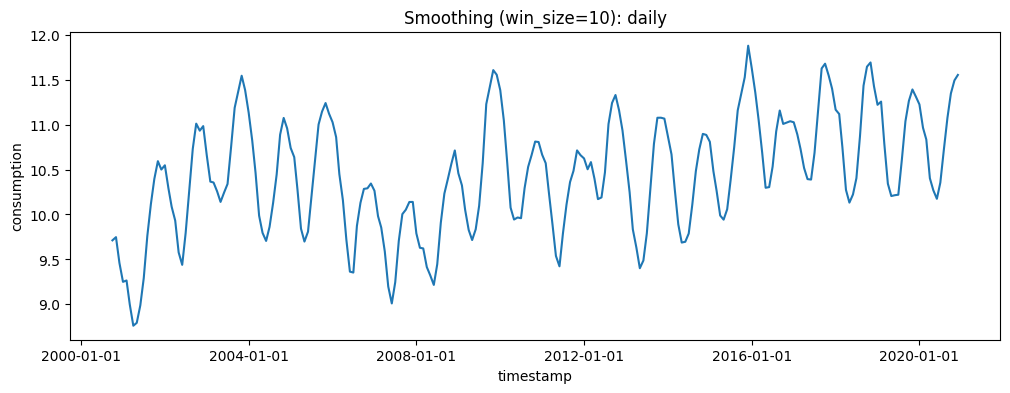

11.52746966205837
{'Persistence': 0.6948625762351472}
{'RMSE': [0.29642918712183886, 0.26590784536663603], 'MAE': [0.2335557794316494, 0.21899273705105607]} {'R2': [0.7689391355678589, 0.6948625762351472]}


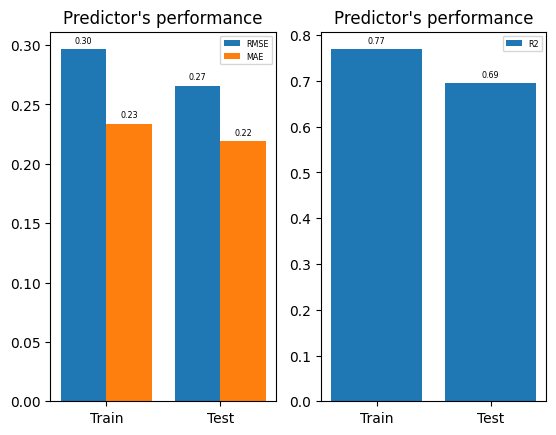

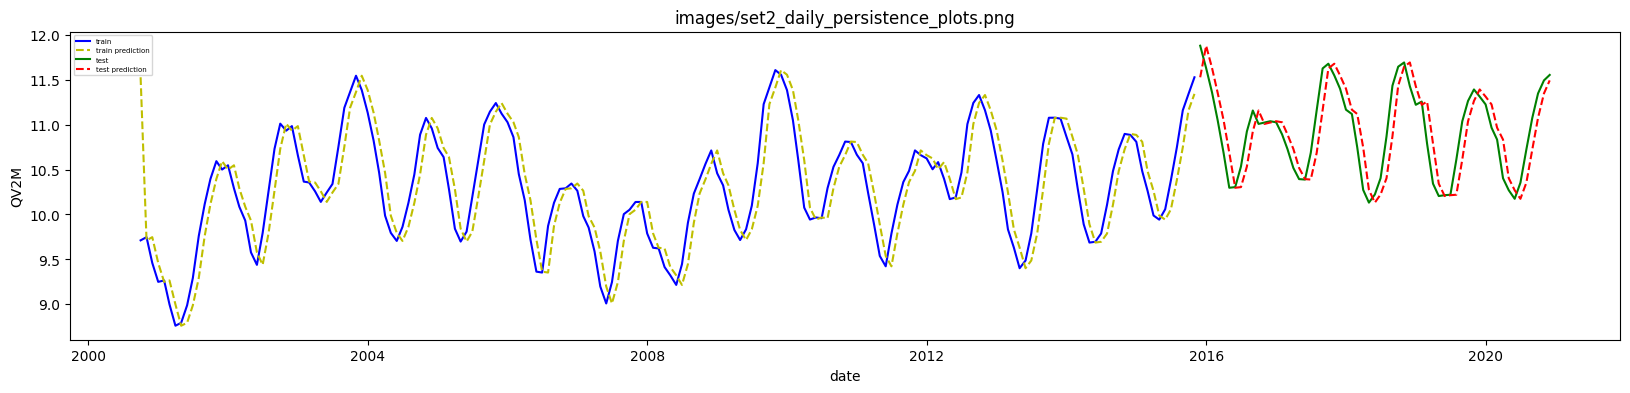

In [322]:
import numpy as np
agg_df = aggregate_by(data, index, 'M') #the most atomic was the one that had the best results using the persistence regressor

WIN_SIZE = 10
rolling = agg_df.rolling(window=WIN_SIZE)
smooth_df_10 = rolling.mean()
smooth_df_10.dropna(inplace=True)

figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(smooth_df_10, title=f'Smoothing (win_size={WIN_SIZE}): daily', x_label='timestamp', y_label='consumption')
savefig('images/set_2_smoothing_10')
show()

train, test = split_dataframe(smooth_df_10, trn_pct=0.75)

fr_mod = PersistenceRegressor()
fr_mod.fit(train)
prd_trn = fr_mod.predict(train)
prd_tst = fr_mod.predict(test)

eval_results['Persistence'] = PREDICTION_MEASURES[measure](test.values, prd_tst)
print(eval_results)

plot_evaluation_results(train.values, prd_trn, test.values, prd_tst, f'images/set2_daily_persistence_eval.png')
savefig('images/set_2_smoting10_results')
plot_forecasting_series(train, test, prd_trn, prd_tst, f'images/set2_daily_persistence_plots.png', x_label=index_col, y_label=target)


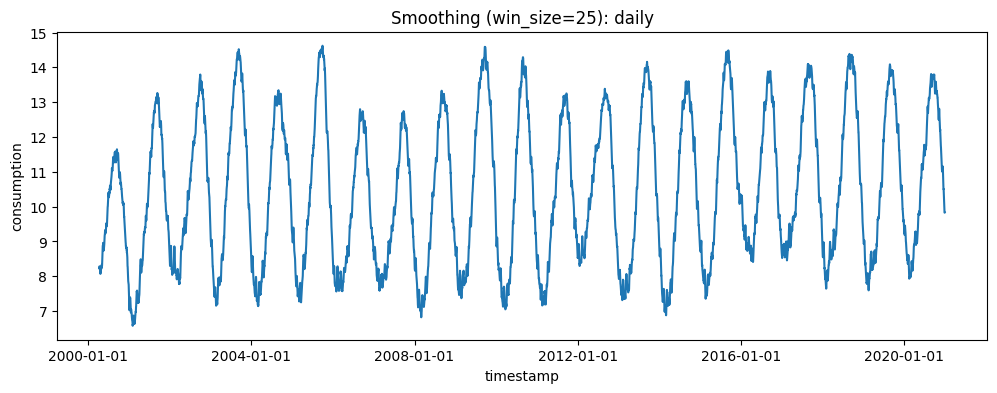

10.710936518883413
{'Persistence': 0.6660583842421546}
{'RMSE': [0.1136002690632306, 0.0635036036371579], 'MAE': [0.06486274276718865, 0.05114259213105075]} {'R2': [0.8454471063565372, 0.6660583842421546]}


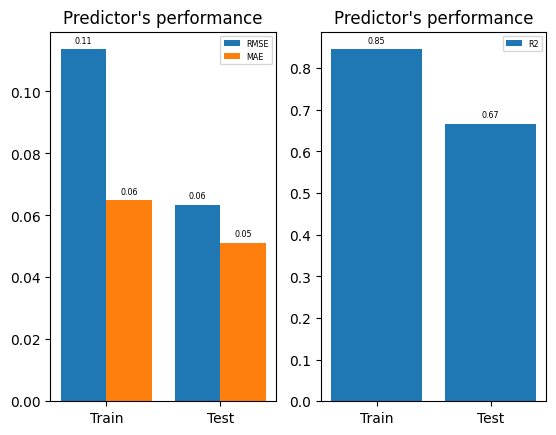

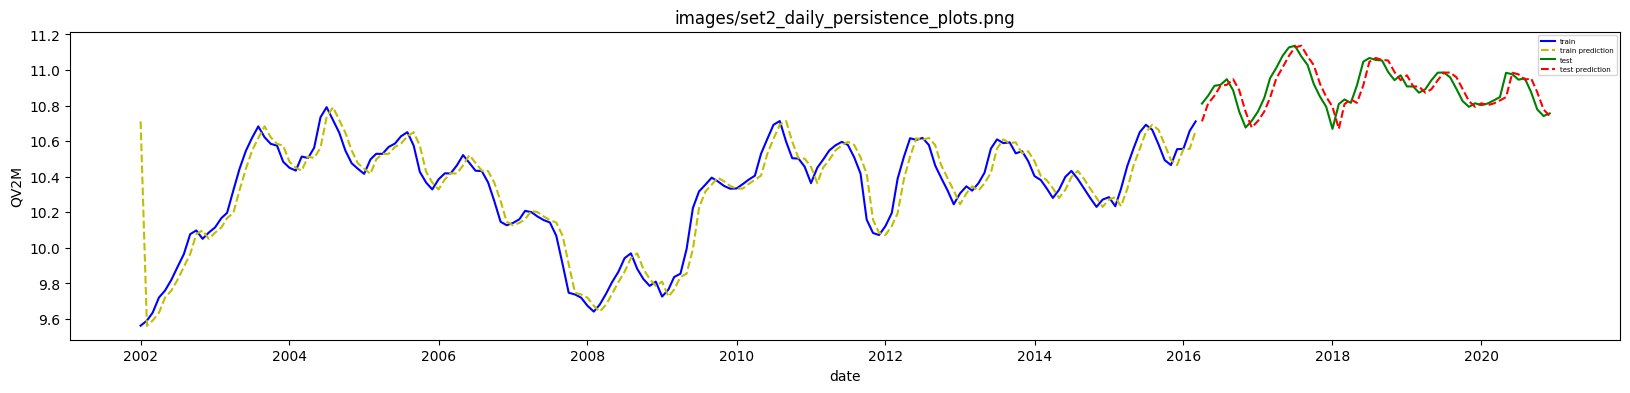

In [323]:
WIN_SIZE = 25
rolling = agg_df.rolling(window=WIN_SIZE)
smooth_df_50 = rolling.mean()
smooth_df_50.dropna(inplace=True)
figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(smooth_df, title=f'Smoothing (win_size={WIN_SIZE}): daily', x_label='timestamp', y_label='consumption')
savefig('images/set_2_smoothing_25')
show()

train, test = split_dataframe(smooth_df_50, trn_pct=0.75)

fr_mod = PersistenceRegressor()
fr_mod.fit(train)
prd_trn = fr_mod.predict(train)
prd_tst = fr_mod.predict(test)

eval_results['Persistence'] = PREDICTION_MEASURES[measure](test.values, prd_tst)
print(eval_results)

plot_evaluation_results(train.values, prd_trn, test.values, prd_tst, f'images/set2_daily_persistence_eval.png')
savefig('images/set_2_smoothing25_results')
plot_forecasting_series(train, test, prd_trn, prd_tst, f'images/set2_daily_persistence_plots.png', x_label=index_col, y_label=target)

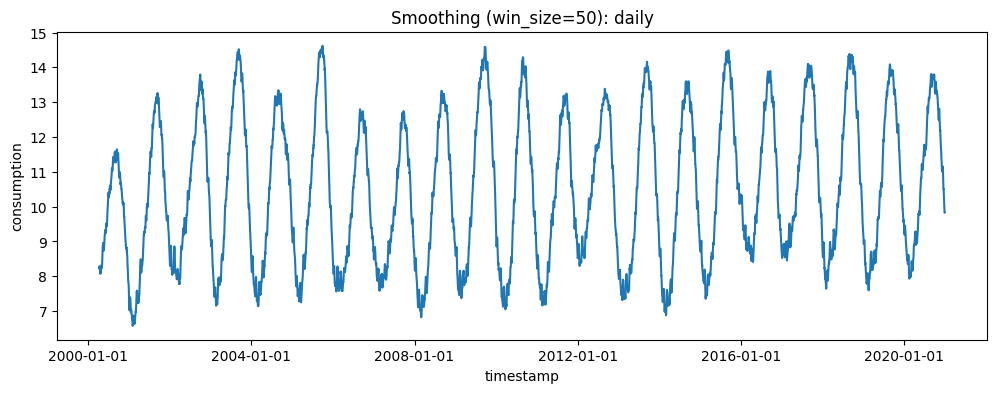

10.636365786323429
{'Persistence': 0.8694667257451226}
{'RMSE': [0.07469376167877965, 0.054632173067343824], 'MAE': [0.04873776022369623, 0.04788793539662814]} {'R2': [0.8438586609730476, 0.8694667257451226]}


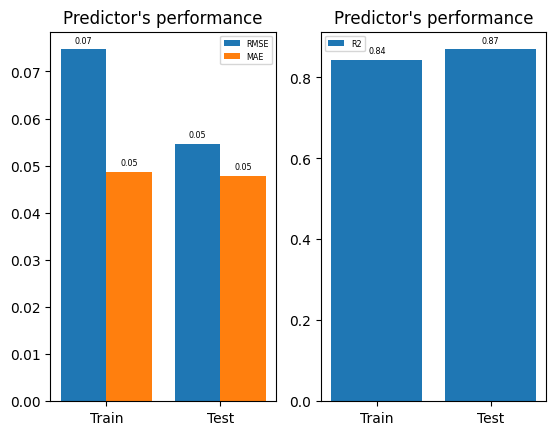

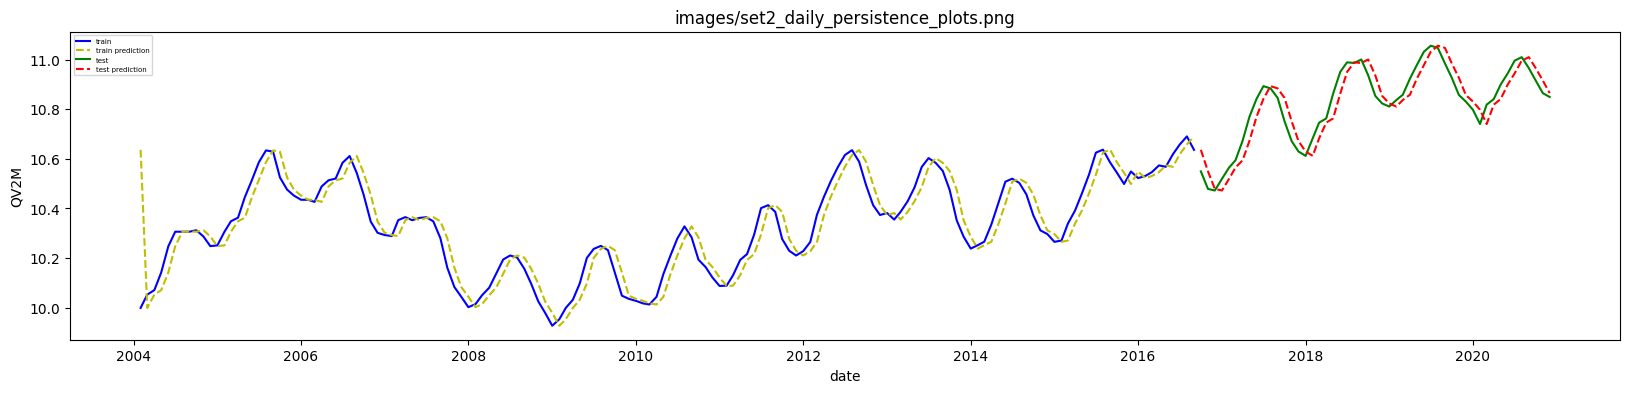

In [324]:
WIN_SIZE = 50
rolling = agg_df.rolling(window=WIN_SIZE)
smooth_df_50 = rolling.mean()
smooth_df_50.dropna(inplace=True)
figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(smooth_df, title=f'Smoothing (win_size={WIN_SIZE}): daily', x_label='timestamp', y_label='consumption')
savefig('images/set_2_smoothing_50')
show()

train, test = split_dataframe(smooth_df_50, trn_pct=0.75)

fr_mod = PersistenceRegressor()
fr_mod.fit(train)
prd_trn = fr_mod.predict(train)
prd_tst = fr_mod.predict(test)

eval_results['Persistence'] = PREDICTION_MEASURES[measure](test.values, prd_tst)
print(eval_results)

plot_evaluation_results(train.values, prd_trn, test.values, prd_tst, f'images/set2_daily_persistence_eval.png')
savefig('images/set_2_smoothing50_results')
plot_forecasting_series(train, test, prd_trn, prd_tst, f'images/set2_daily_persistence_plots.png', x_label=index_col, y_label=target)

#### Transformation: differentiation

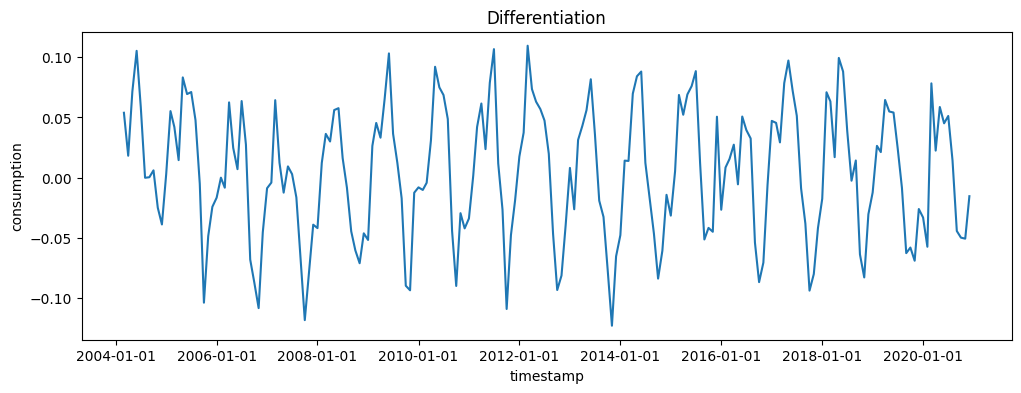

-0.05407268817204347
{'Persistence': 0.38209446484127496}
{'RMSE': [0.04337535117251742, 0.04281893753737116], 'MAE': [0.03532958411690487, 0.03376303646857339]} {'R2': [0.3521346550384301, 0.38209446484127496]}


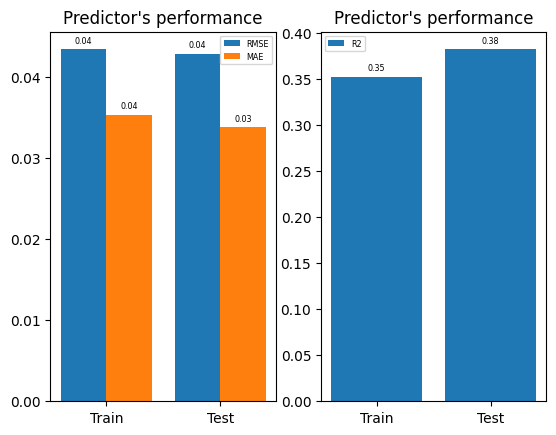

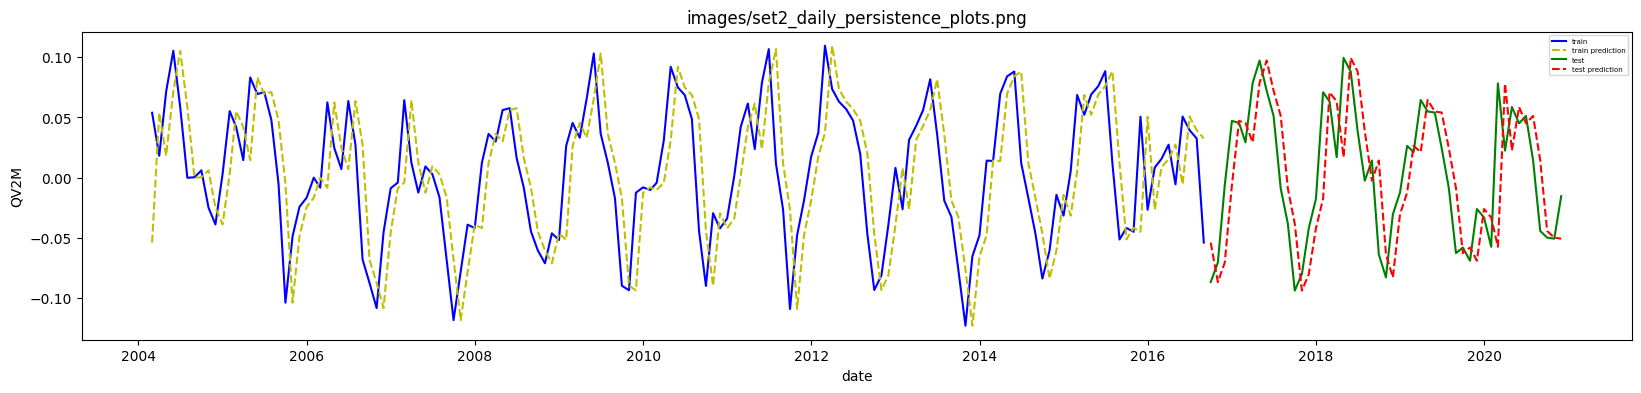

In [325]:
diff_df = smooth_df_50.diff() #the best until now
diff_df.dropna(inplace=True)

figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(diff_df, title='Differentiation', x_label='timestamp', y_label='consumption')
savefig('images/set_2_diff')
show()

train, test = split_dataframe(diff_df, trn_pct=0.75)

fr_mod = PersistenceRegressor()
fr_mod.fit(train)
prd_trn = fr_mod.predict(train)
prd_tst = fr_mod.predict(test)

eval_results['Persistence'] = PREDICTION_MEASURES[measure](test.values, prd_tst)
print(eval_results)

plot_evaluation_results(train.values, prd_trn, test.values, prd_tst, f'images/set2_daily_persistence_eval.png')
savefig('images/set_2_diff_results')
plot_forecasting_series(train, test, prd_trn, prd_tst, f'images/set2_daily_persistence_plots.png', x_label=index_col, y_label=target)

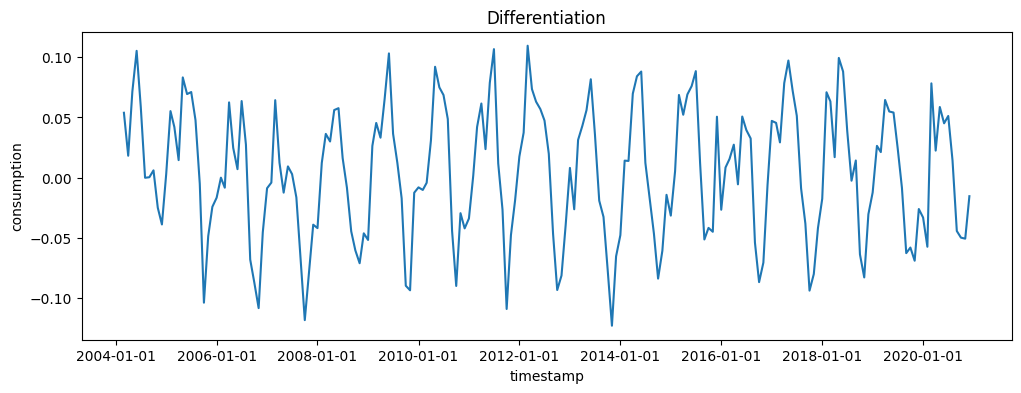

-0.08657290322580913
{'Persistence': -1.026958002110049}
{'RMSE': [0.05734755061900224, 0.06095236155770185], 'MAE': [0.045345249578897275, 0.04827478713250282]} {'R2': [-0.8112039472940575, -1.026958002110049]}


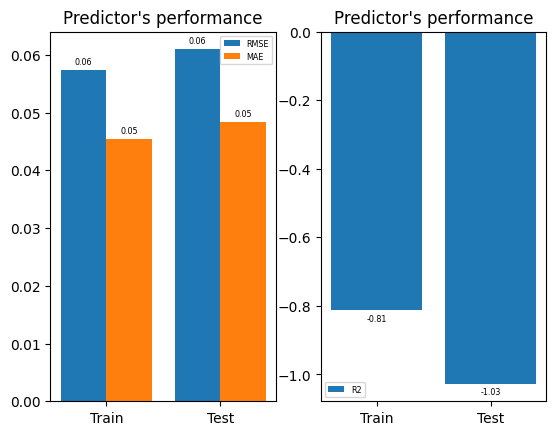

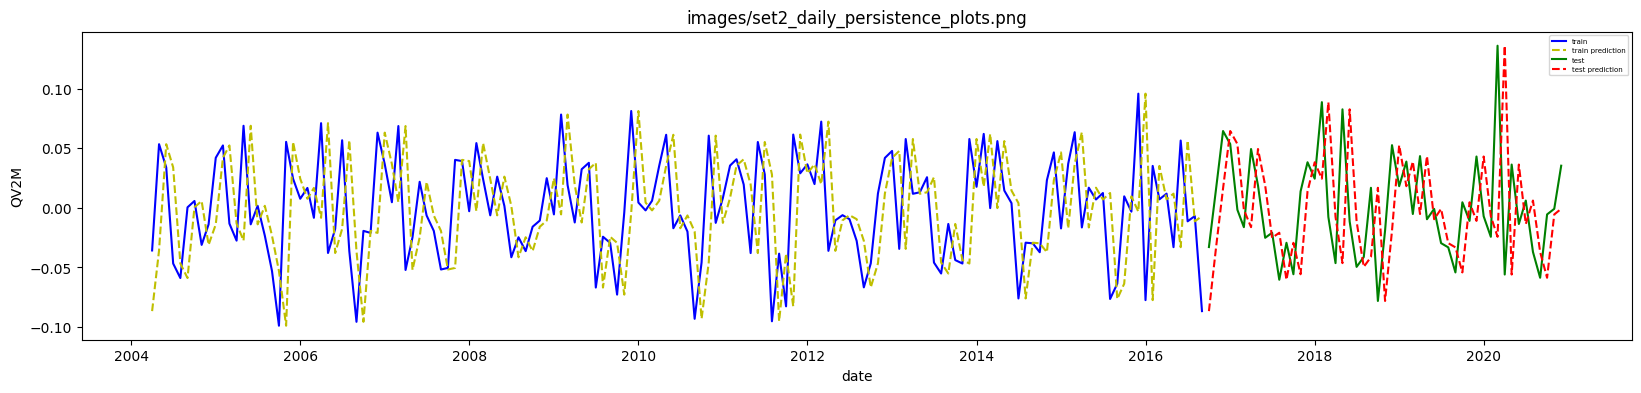

In [326]:
diff_diff_df = diff_df.diff()
diff_diff_df.dropna(inplace=True)

figure(figsize=(3*HEIGHT, HEIGHT))
plot_series(diff_df, title='Differentiation', x_label='timestamp', y_label='consumption')
savefig('images/set_2_diff2')
show()

train, test = split_dataframe(diff_diff_df, trn_pct=0.75)

fr_mod = PersistenceRegressor()
fr_mod.fit(train)
prd_trn = fr_mod.predict(train)
prd_tst = fr_mod.predict(test)

eval_results['Persistence'] = PREDICTION_MEASURES[measure](test.values, prd_tst)
print(eval_results)

plot_evaluation_results(train.values, prd_trn, test.values, prd_tst, f'images/set2_daily_persistence_eval.png')
savefig('images/set_2_diff2_results')
plot_forecasting_series(train, test, prd_trn, prd_tst, f'images/set2_daily_persistence_plots.png', x_label=index_col, y_label=target)